In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
# for interactive visualizations
import plotly.offline as py
import plotly.figure_factory as ff
import statsmodels.tsa.api as smt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import (GradientBoostingRegressor,AdaBoostRegressor)
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy import stats; from scipy.stats import zscore, norm, randint

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
traindat = pd.read_csv("/Users/preethamvignesh/Desktop/OpenAq_Data/US_StateDailyAvg/California_DlyAvg_PM25.csv")
traindat = traindat[traindat.pm25 > 0]
traindat['date'] = pd.to_datetime(traindat['date'])
traindat = traindat[(traindat['date'] >= '1/8/2019') & (traindat['date'] <= '3/19/2020')]
traindat.head()


,Unnamed: 0,date,state,pm25,longitude,latitude
360,360,2019-01-08,California,7.627037,-121.493629,38.576668
361,361,2019-01-09,California,7.029882,-121.493629,38.576668
362,362,2019-01-10,California,9.152287,-121.493629,38.576668
363,363,2019-01-11,California,11.489377,-121.493629,38.576668
364,364,2019-01-12,California,8.882937,-121.493629,38.576668


Text(0, 0.5, 'Count')

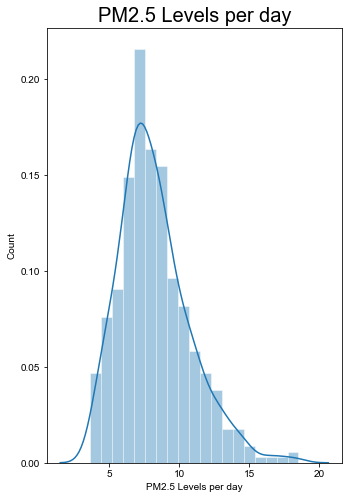

In [3]:
#sales for each day and monthly
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 3, 1)
sns.set(style = 'whitegrid')
sns.distplot(traindat['pm25'])
plt.title('PM2.5 Levels per day', fontsize = 20)
plt.xlabel('PM2.5 Levels per day')
plt.ylabel('Count')

In [4]:
dailypm25 = traindat
dailypm25.drop(['Unnamed: 0','longitude','latitude','state'],axis=1,inplace=True)
original_df = dailypm25
dailypm25

,date,pm25
360,2019-01-08,7.627037
361,2019-01-09,7.029882
362,2019-01-10,9.152287
363,2019-01-11,11.489377
364,2019-01-12,8.882937
...,...,...
792,2020-03-15,3.874888
793,2020-03-16,4.118884
794,2020-03-17,4.238078
795,2020-03-18,4.622812


## Stationarity Stuffs

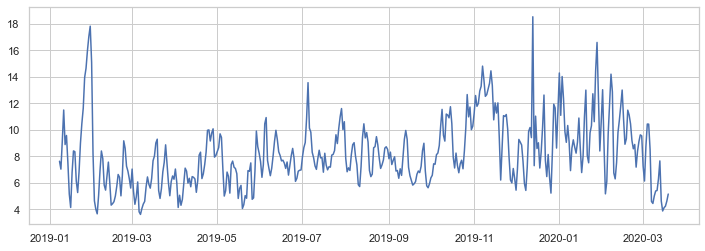

In [5]:
#daily line plot
x = dailypm25.date.astype('datetime64[D]')
y = dailypm25['pm25']
plt.figure(figsize=(12,4))
plt.plot(x, y)
# ticks = np.arange(x[0], x[-1], (x[-1] - x[0]).astype('timedelta64[D]') / 20)
# plt.xticks(ticks, ticks)
# plt.gca().tick_params('x', labelrotation=90, labelsize=10)

In [6]:
def diff_pm25(data):
    data['pm25_diff'] = data.pm25.diff()
    data = data.dropna()
    
    data.to_csv("~/Downloads/pm25_statinary_diff.csv")
    return data

stationary_df = diff_pm25(dailypm25)

# #sales for each day and monthly
# plt.rcParams['figure.figsize'] = (18, 12)

# plt.subplot(2,1,1)
# sns.lineplot('date','pm25',data=dailypm25,color='royalblue',label='Daily PM2.5')
# # yrly_pm25 = monthlypm25.groupby(monthlypm25.date.dt.year)['pm25'].mean().reset_index()
# # yrly_pm25.date = pd.to_datetime(yrly_pm25.date,format='%Y')
# # sns.lineplot((yrly_pm25.date+datetime.timedelta(6*365/12)),yrly_pm25.pm25,data=yrly_pm25,
# #             color='red',label="mean_sales")
# plt.title('Total Daily PM2.5', fontsize = 20)


# plt.subplot(2,1,2)
# sns.lineplot('date','pm25_diff',data=stationary_df,color='royalblue',label='Daily PM2.5 after differencing')
# # yrly_pm25 = stationary_df.groupby(stationary_df.date.dt.year)['pm25_diff'].mean().reset_index()
# # yrly_pm25.date = pd.to_datetime(yrly_pm25.date,format='%Y')
# # sns.lineplot((yrly_pm25.date+datetime.timedelta(6*365/12)),yrly_pm25.pm25_diff,data=stationary_df,
# #             color='red',label="mean_pm25")
# plt.title('Daily PM2.5 after differencing', fontsize = 20)

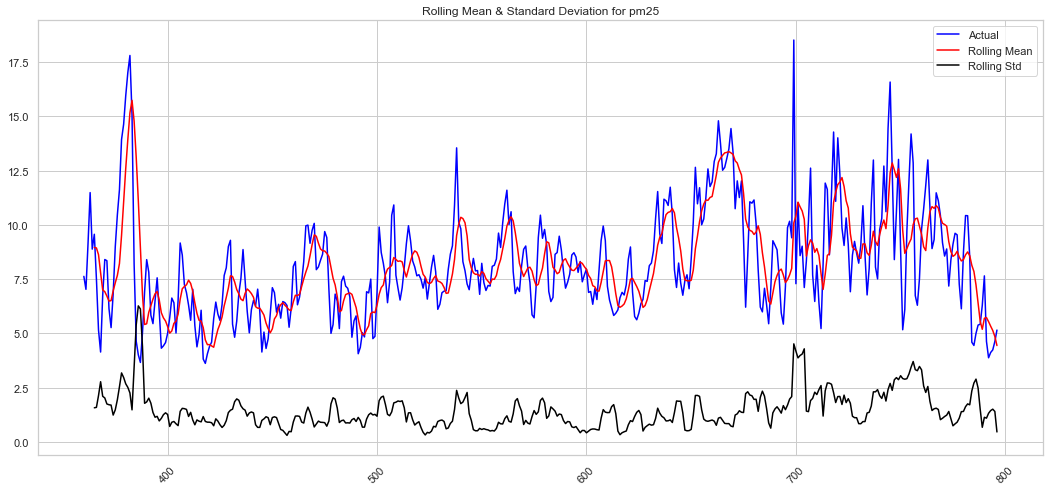

Results of Dickey-Fuller Test:
Test Statistic                  -4.035450
p-value                          0.001236
# Lags Used                      9.000000
Number of Observations Used    427.000000
Critical Value (1%)             -3.445758
Critical Value (5%)             -2.868333
Critical Value (10%)            -2.570388
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller
def stationarity_check(df, ts):
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 6, center = False).mean()
    rolstd = df[ts].rolling(window = 6, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Actual')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
stationarity_check(dailypm25,"pm25")

In [8]:
stationary_df

,date,pm25,pm25_diff
361,2019-01-09,7.029882,-0.597155
362,2019-01-10,9.152287,2.122405
363,2019-01-11,11.489377,2.337090
364,2019-01-12,8.882937,-2.606439
365,2019-01-13,9.567906,0.684969
...,...,...,...
792,2020-03-15,3.874888,-0.754195
793,2020-03-16,4.118884,0.243995
794,2020-03-17,4.238078,0.119194
795,2020-03-18,4.622812,0.384734


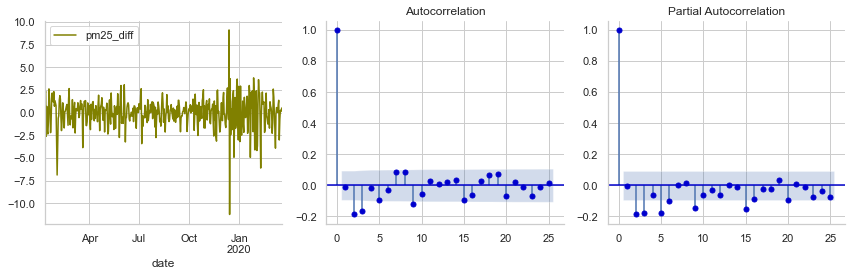

In [9]:
#Auto correlation function (ACF) and Partial auto correlation function (PACF)
def acf_pacf(data, lags=None):
    #convert dataframe to datetime index
    dt_data = data.set_index('date').drop('pm25',axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1,3)
    raw = plt.subplot2grid(layout, (0,0))
    acf = plt.subplot2grid(layout, (0,1))
    pacf = plt.subplot2grid(layout, (0,2))
    
    dt_data.plot(ax=raw, figsize=(12,4), color='olive')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color="mediumblue")
    
    sns.despine()
    plt.tight_layout()
    
acf_pacf(stationary_df,lags=25)

In [10]:
%run -i '/Users/preethamvignesh/Desktop/ML_EIT/openAQ/arange_supervised.py'
# %run -i '/Users/preethamvignesh/Desktop/ML_EIT/openAQ/predict_df.py'

model_df = arange_supervised(stationary_df)
model_df

,date,pm25,pm25_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,2019-01-15,5.151872,-2.359802,-2.056231,0.684969,-2.606439,2.337090,2.122405,-0.597155
1,2019-01-16,4.139375,-1.012497,-2.359802,-2.056231,0.684969,-2.606439,2.337090,2.122405
2,2019-01-17,6.755920,2.616545,-1.012497,-2.359802,-2.056231,0.684969,-2.606439,2.337090
3,2019-01-18,8.404254,1.648334,2.616545,-1.012497,-2.359802,-2.056231,0.684969,-2.606439
4,2019-01-19,8.349329,-0.054925,1.648334,2.616545,-1.012497,-2.359802,-2.056231,0.684969
...,...,...,...,...,...,...,...,...,...
425,2020-03-15,3.874888,-0.754195,-3.021210,1.360695,0.870562,0.035823,0.381440,0.559236
426,2020-03-16,4.118884,0.243995,-0.754195,-3.021210,1.360695,0.870562,0.035823,0.381440
427,2020-03-17,4.238078,0.119194,0.243995,-0.754195,-3.021210,1.360695,0.870562,0.035823
428,2020-03-18,4.622812,0.384734,0.119194,0.243995,-0.754195,-3.021210,1.360695,0.870562


In [11]:
#Loading the model fit values
pm25_mdl_df = pd.read_csv('~/Downloads/pm25_model_df.csv')

#Train and Split the datasets
data = pm25_mdl_df.drop(['pm25','date'],axis=1)
train, test = data[0:-84].values,data[-84:].values
train.shape,test.shape

((346, 7), (84, 7))

In [12]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

y_train.shape

(346,)

In [13]:
# Modeling functions
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [14]:
def load_original_df():
    #load in original dataframe without scaling applied
#     original_df = pd.read_csv('/Users/preethamvignesh/Desktop/OpenAq_Data/US_StateDailyAvg/California_DlyAvg_PM25.csv')
#     original_df.drop(['Unnamed: 0','longitude','latitude','state'],axis=1,inplace=True)
#     original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
#     original_df = original_df.groupby('date')['pm25'].mean().reset_index()
#     original_df.date = pd.to_datetime(original_df.date)

    traindat = pd.read_csv("/Users/preethamvignesh/Desktop/OpenAq_Data/US_StateDailyAvg/California_DlyAvg_PM25.csv")
    traindat = traindat[traindat.pm25 > 0]
    traindat['date'] = pd.to_datetime(traindat['date'])
    traindat = traindat[(traindat['date'] >= '1/8/2019') & (traindat['date'] <= '3/19/2020')]
    traindat.drop(['Unnamed: 0','longitude','latitude','state'],axis=1,inplace=True)
    return traindat

In [15]:
original_df = load_original_df()
original_df

,date,pm25
360,2019-01-08,7.627037
361,2019-01-09,7.029882
362,2019-01-10,9.152287
363,2019-01-11,11.489377
364,2019-01-12,8.882937
...,...,...
792,2020-03-15,3.874888
793,2020-03-16,4.118884
794,2020-03-17,4.238078
795,2020-03-18,4.622812


In [16]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    pm25_dates = list(original_df[-85:].date)
    act_pm25 = list(original_df[-85:].pm25)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_pm25[index])
        result_dict['date'] = pm25_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [17]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    #calc. of Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(original_df.pm25[-84:], unscaled_df.pred_value[-84:]))
    #calc. of Mean Absolute Error
    mae = mean_absolute_error(original_df.pm25[-84:], unscaled_df.pred_value[-84:])
    #calc. Mean Squared Error
    mse = mean_squared_error(original_df.pm25[-84:],unscaled_df.pred_value[-84:])
    #calc. of R2 value
    r2 = r2_score(original_df.pm25[-84:], unscaled_df.pred_value[-84:])
    model_scores[model_name] = [rmse, mae, mse, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}")

In [18]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.pm25, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "PM2.5",
           title = f"{model_name} PM2.5 Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
#     plt.savefig(f'/Users/preethamvignesh/Downloads/{model_name}_forecast.png')

In [19]:
print(X_train.shape,y_train.shape,X_test.shape, y_test.shape)


(346, 6) (346,) (84, 6) (84,)


In [20]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

#### Linear Regression

RMSE: 2.110417972537881
MAE: 1.7077309603753459
MSE: 4.453864018810899
R2 Score: 0.4122702277631528


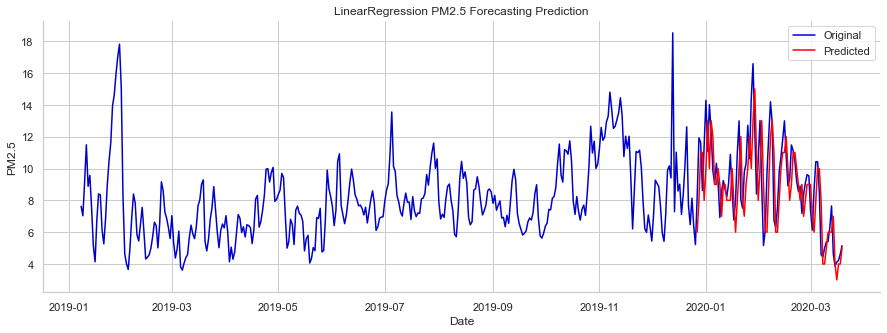

In [21]:
run_model(train, test, LinearRegression(), 'LinearRegression')

In [22]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['LinearRegression'][0]})
mae1 = list({model_scores['LinearRegression'][1]})
mse1 = list({model_scores['LinearRegression'][2]})
r21 = list({model_scores['LinearRegression'][3]})
results_temp = pd.DataFrame({'Method':['Linear Regression'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'1'})

# results = pd.concat([results,results_temp])
results = results_temp[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.41227


#### Random Forest Regressor

RMSE: 2.3001173039156635
MAE: 1.8628978671345733
MSE: 5.29053961177226
R2 Score: 0.3018629154585003


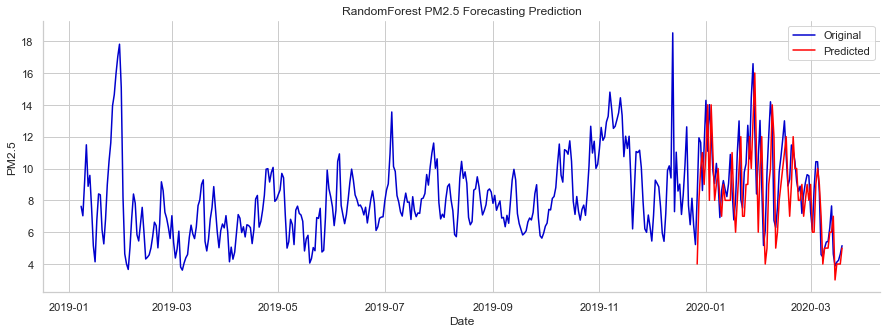

In [23]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

In [24]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['RandomForest'][0]})
mae1 = list({model_scores['RandomForest'][1]})
mse1 = list({model_scores['RandomForest'][2]})
r21 = list({model_scores['RandomForest'][3]})
results_temp = pd.DataFrame({'Method':['Random Forest'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'2'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863


#### DecisionTreeRegressor

RMSE: 2.8201864739123477
MAE: 2.09619108706147
MSE: 7.95345174763816
R2 Score: -0.0495337002641878


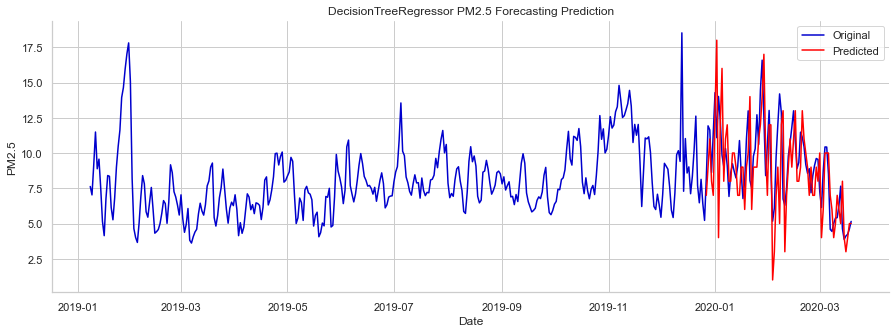

In [25]:
run_model(train, test, DecisionTreeRegressor(), 'DecisionTreeRegressor')

In [26]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['DecisionTreeRegressor'][0]})
mae1 = list({model_scores['DecisionTreeRegressor'][1]})
mse1 = list({model_scores['DecisionTreeRegressor'][2]})
r21 = list({model_scores['DecisionTreeRegressor'][3]})
results_temp = pd.DataFrame({'Method':['DecisionTreeRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'3'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534


#### Gradient Boost Regressor

RMSE: 2.542824345673762
MAE: 2.0032237464685707
MSE: 6.4659556529511955
R2 Score: 0.14675557512482063


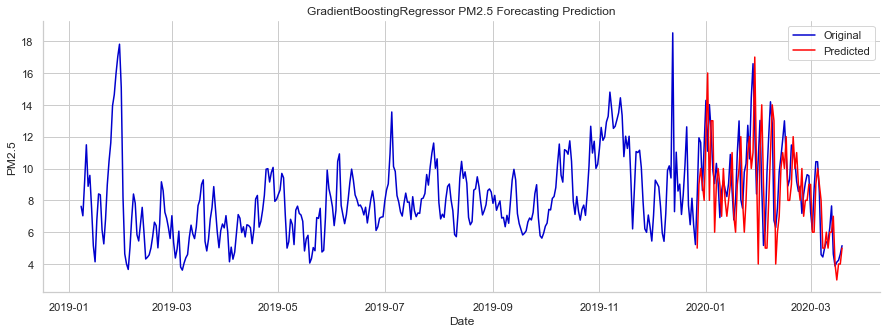

In [27]:
run_model(train, test, GradientBoostingRegressor(), 'GradientBoostingRegressor')

In [28]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['GradientBoostingRegressor'][0]})
mae1 = list({model_scores['GradientBoostingRegressor'][1]})
mse1 = list({model_scores['GradientBoostingRegressor'][2]})
r21 = list({model_scores['GradientBoostingRegressor'][3]})
results_temp = pd.DataFrame({'Method':['GradientBoostingRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'4'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534
4,GradientBoostingRegressor,2.542824,2.003224,6.465956,0.146756


#### Ada Boost Regressor

RMSE: 2.3268335808834695
MAE: 1.9070239712693722
MSE: 5.41415451312699
R2 Score: 0.2855507520176208


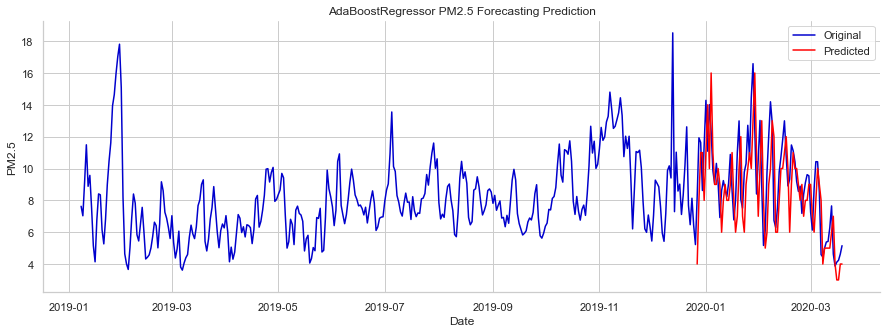

In [29]:
run_model(train, test, AdaBoostRegressor(), 'AdaBoostRegressor')

In [30]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['AdaBoostRegressor'][0]})
mae1 = list({model_scores['AdaBoostRegressor'][1]})
mse1 = list({model_scores['AdaBoostRegressor'][2]})
r21 = list({model_scores['AdaBoostRegressor'][3]})
results_temp = pd.DataFrame({'Method':['AdaBoostRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'5'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534
4,GradientBoostingRegressor,2.542824,2.003224,6.465956,0.146756
5,AdaBoostRegressor,2.326834,1.907024,5.414155,0.285551


### XG Boost

RMSE: 2.3933001810433687
MAE: 1.9379246730075035
MSE: 5.7278857565822205
R2 Score: 0.24415092672417726


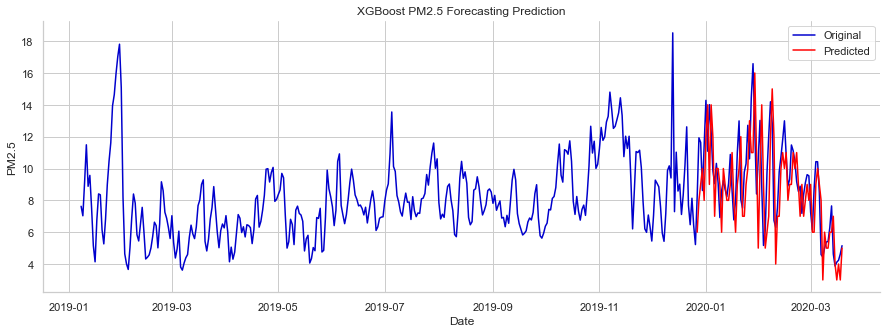

In [31]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [32]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['XGBoost'][0]})
mae1 = list({model_scores['XGBoost'][1]})
mse1 = list({model_scores['XGBoost'][2]})
r21 = list({model_scores['XGBoost'][3]})
results_temp = pd.DataFrame({'Method':['XGBoost'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'6'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534
4,GradientBoostingRegressor,2.542824,2.003224,6.465956,0.146756
5,AdaBoostRegressor,2.326834,1.907024,5.414155,0.285551
6,XGBoost,2.393300,1.937925,5.727886,0.244151


### KNeighborsRegressor (KNN Regressor)

RMSE: 2.2168949569664136
MAE: 1.75983507456196
MSE: 4.914623250223117
R2 Score: 0.35146865928459237


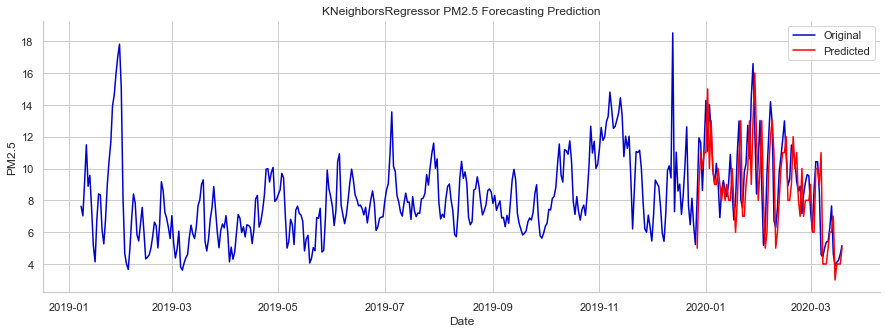

In [33]:
run_model(train, test, KNeighborsRegressor(n_neighbors=3), 'KNeighborsRegressor')

In [34]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['KNeighborsRegressor'][0]})
mae1 = list({model_scores['KNeighborsRegressor'][1]})
mse1 = list({model_scores['KNeighborsRegressor'][2]})
r21 = list({model_scores['KNeighborsRegressor'][3]})
results_temp = pd.DataFrame({'Method':['KNeighborsRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'7'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534
4,GradientBoostingRegressor,2.542824,2.003224,6.465956,0.146756
5,AdaBoostRegressor,2.326834,1.907024,5.414155,0.285551
6,XGBoost,2.393300,1.937925,5.727886,0.244151
7,KNeighborsRegressor,2.216895,1.759835,4.914623,0.351469


#### Support Vector Regressor

RMSE: 2.134133408892353
MAE: 1.7210885630348058
MSE: 4.554525406950496
R2 Score: 0.39898699898147905


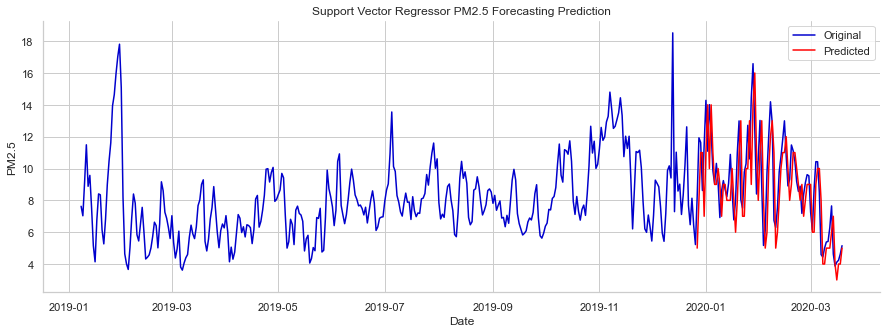

In [35]:
run_model(train, test, SVR(kernel='linear'), 'Support Vector Regressor')

In [36]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['Support Vector Regressor'][0]})
mae1 = list({model_scores['Support Vector Regressor'][1]})
mse1 = list({model_scores['Support Vector Regressor'][2]})
r21 = list({model_scores['Support Vector Regressor'][3]})
results_temp = pd.DataFrame({'Method':['Support Vector Regressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'8'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534
4,GradientBoostingRegressor,2.542824,2.003224,6.465956,0.146756
5,AdaBoostRegressor,2.326834,1.907024,5.414155,0.285551
6,XGBoost,2.393300,1.937925,5.727886,0.244151
7,KNeighborsRegressor,2.216895,1.759835,4.914623,0.351469
8,Support Vector Regressor,2.134133,1.721089,4.554525,0.398987


### LSTM

In [37]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    
    
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
#     plot_results(unscaled_df, original_df, 'LSTM')
    

    loss_train = history.history['loss']
    epochs = range(1,201)
    plt.plot(epochs, loss_train, 'g', label='Training Loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch 1/200
346/346 [==============================] - 10s 810us/step - loss: 0.0243
Epoch 2/200
346/346 [==============================] - 0s 835us/step - loss: 0.0232
Epoch 3/200
346/346 [==============================] - 0s 795us/step - loss: 0.0222
Epoch 4/200
346/346 [==============================] - 0s 791us/step - loss: 0.0214
Epoch 5/200
346/346 [==============================] - 0s 742us/step - loss: 0.0209
Epoch 6/200
346/346 [==============================] - 0s 728us/step - loss: 0.0204
Epoch 7/200
346/346 [==============================] - 0s 717us/step - loss: 0.0200
Epoch 8/200
346/346 [==============================] - 0s 718us/step - loss: 0.0198
Epoch 9/200
346/346 [==============================] - 0s 711us/step - loss: 0.0196
Epoch 10/200
346/346 [==============================] - 0s 752us/step - loss: 0.0194
Epoch 11/200
346/346 [==============================] - 0s 780us/step - loss: 0.0194
Epoch 12/200
346/346 [==============================] - 0s 768us/step - l

346/346 [==============================] - 0s 771us/step - loss: 0.0160
Epoch 98/200
346/346 [==============================] - 0s 815us/step - loss: 0.0160
Epoch 99/200
346/346 [==============================] - 0s 780us/step - loss: 0.0159
Epoch 100/200
346/346 [==============================] - 0s 804us/step - loss: 0.0159
Epoch 101/200
346/346 [==============================] - 0s 783us/step - loss: 0.0158
Epoch 102/200
346/346 [==============================] - 0s 791us/step - loss: 0.0158
Epoch 103/200
346/346 [==============================] - 0s 783us/step - loss: 0.0158
Epoch 104/200
346/346 [==============================] - 0s 774us/step - loss: 0.0157
Epoch 105/200
346/346 [==============================] - 0s 818us/step - loss: 0.0157
Epoch 106/200
346/346 [==============================] - 0s 764us/step - loss: 0.0157
Epoch 107/200
346/346 [==============================] - 0s 841us/step - loss: 0.0156
Epoch 108/200
346/346 [==============================] - 0s 789us/step

346/346 [==============================] - 0s 712us/step - loss: 0.0143
Epoch 193/200
346/346 [==============================] - 0s 711us/step - loss: 0.0143
Epoch 194/200
346/346 [==============================] - 0s 712us/step - loss: 0.0143
Epoch 195/200
346/346 [==============================] - 0s 712us/step - loss: 0.0143
Epoch 196/200
346/346 [==============================] - 0s 720us/step - loss: 0.0143
Epoch 197/200
346/346 [==============================] - 0s 717us/step - loss: 0.0143
Epoch 198/200
346/346 [==============================] - 0s 713us/step - loss: 0.0143
Epoch 199/200
346/346 [==============================] - 0s 719us/step - loss: 0.0143
Epoch 200/200
346/346 [==============================] - 0s 718us/step - loss: 0.0143
RMSE: 2.626031384074091
MAE: 1.9831254250973873
MSE: 6.896040830142087
R2 Score: 0.09000174021534524


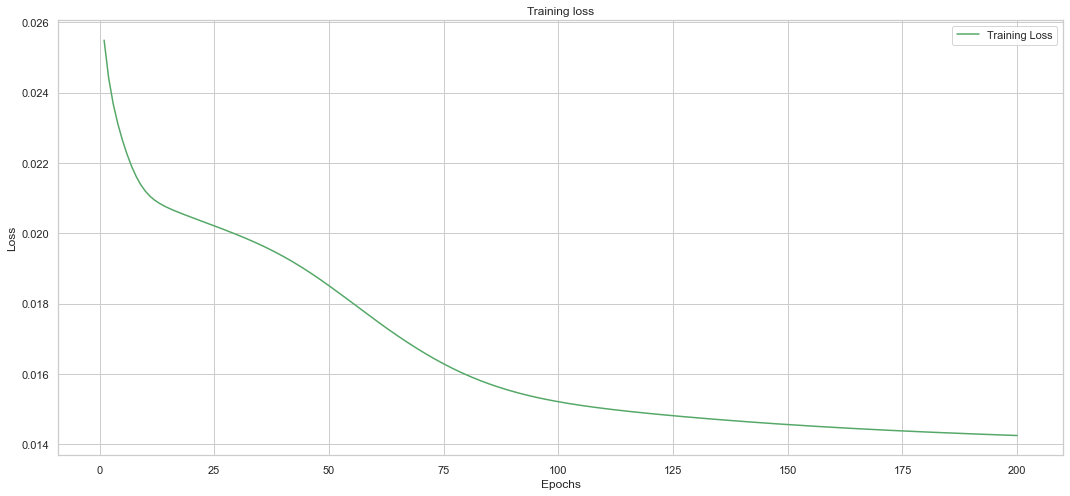

In [38]:
lstm_model(train, test)

In [39]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['LSTM'][0]})
mae1 = list({model_scores['LSTM'][1]})
mse1 = list({model_scores['LSTM'][2]})
r21 = list({model_scores['LSTM'][3]})
results_temp = pd.DataFrame({'Method':['LSTM'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'10'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

,Method,RMSE,MAE,MSE,R_square
1,Linear Regression,2.110418,1.707731,4.453864,0.412270
2,Random Forest,2.300117,1.862898,5.290540,0.301863
3,DecisionTreeRegressor,2.820186,2.096191,7.953452,-0.049534
4,GradientBoostingRegressor,2.542824,2.003224,6.465956,0.146756
5,AdaBoostRegressor,2.326834,1.907024,5.414155,0.285551
6,XGBoost,2.393300,1.937925,5.727886,0.244151
7,KNeighborsRegressor,2.216895,1.759835,4.914623,0.351469
8,Support Vector Regressor,2.134133,1.721089,4.554525,0.398987
10,LSTM,2.626031,1.983125,6.896041,0.090002
